# Prepare Input Data for Model Experiments

In this work, I tried to compare several models below:

- Model1 (baseline model): Ding et al(2013) original event embedding model with mini-batch gradient descent
- Model2: original model + **incorporating learning parameter E (word vector matrix)**
- Model2: original model + **dynamic margin loss function**
- Model3: original model + **triplet loss function**
- Model4: original model + incorporating learning parameter E (word vector matrix) + **rnn-cell** (In progress)

Also, our event embedding model's input data are:

- (S,V,O) triplets extracted from **StanfordCoreNLP's openIE**
- (S,V,O) triplets extracted from **NP and VP chunker**

## For convenience, merge seperated data

In [32]:
dat_path = '/home/junhyuki/DLproject/DAT'
for i, year in enumerate(np.arange(2012, 2019)):
    if i == 0:
        df = pd.read_csv(dat_path + '/2-SVO/SVO_{}.csv'.format(year), encoding='utf-8-sig')
        print('{} data: '.format(year) + str(df.shape))
    else:
        df_add = pd.read_csv(dat_path + '/2-SVO/SVO_{}.csv'.format(year), encoding='utf-8-sig')
        print('{} data: '.format(year) + str(df_add.shape))
        df = df.append(df_add)
print('Merged data: ' + str(df.shape))

df.to_csv(dat_path + '/2-SVO/SVO.csv', index=False, encoding='utf-8-sig')
df.head()

2012 data: (194385, 8)
2013 data: (171902, 8)
2014 data: (142133, 8)
2015 data: (470668, 8)
2016 data: (251685, 8)
2017 data: (151148, 8)
2018 data: (103104, 8)
Merged data: (1485025, 8)


,connected_url,keywords,timestamp,clean_title,location,subject,verb,object
0,http://www.reuters.com/article/2012/01/02/us-f...,Juan Salceto;Stephen Glatstein;US;FOOTBALL;ACC...,20120101,Oakland Raiders fan falls from bleachers after...,NaN,Oakland Raiders fan,falls after,game
1,http://www.reuters.com/article/2012/01/02/us-n...,Ian Cole;Justin Abdelkader;US;NHL;BLUES;COLE;N...,20120101,Blues' Cole suspended for three games,NaN,Blues ' Cole,suspended for,three games
2,http://www.reuters.com/article/2012/01/02/us-n...,Barry Trotz;Brendan Morrison;Jarome Iginla;Kev...,20120101,Kostitsyn's hat-trick helps Predators douse Fl...,NaN,Kostitsyn,has,hat-trick
3,http://www.reuters.com/article/2012/01/02/us-n...,Mark Leffingwell;Tim Tebow;US;NFL;BRONCOS;Spor...,20120101,"Broncos clinch AFC West, snap playoff drought",NaN,Broncos,clinch,AFC West
4,http://www.reuters.com/article/2012/01/02/us-c...,US;CHINA;LAWYER;Crime / Law / Justice;Fundamen...,20120101,China dissident-lawyer Gao jailed in far west,NaN,China dissident-lawyer Gao,jailed in,far west


In [2]:
dat_path = '/home/junhyuki/DLproject/DAT'
df = pd.read_csv(dat_path + '/2-SVO/SVO.csv', encoding='utf-8-sig')

In [33]:
dat_path = '/home/junhyuki/DLproject/DAT'
for i, year in enumerate(np.arange(2012, 2019)):
    if i == 0:
        df = pd.read_csv(dat_path + '/2-SVO/SVO_chunker_{}.csv'.format(year), encoding='utf-8-sig')
        print('{} data: '.format(year) + str(df.shape))
    else:
        df_add = pd.read_csv(dat_path + '/2-SVO/SVO_chunker_{}.csv'.format(year), encoding='utf-8-sig')
        print('{} data: '.format(year) + str(df_add.shape))
        df = df.append(df_add)
print('Merged data: ' + str(df.shape))

df.to_csv(dat_path + '/2-SVO/SVO_chunker.csv', index=False, encoding='utf-8-sig')
df.head()

2012 data: (234381, 8)
2013 data: (208391, 8)
2014 data: (172938, 8)
2015 data: (592160, 8)
2016 data: (313391, 8)
2017 data: (189041, 8)
2018 data: (137221, 8)
Merged data: (1847523, 8)


,connected_url,keywords,timestamp,clean_title,location,subject,verb,object
0,http://www.reuters.com/article/2012/01/02/us-f...,Juan Salceto;Stephen Glatstein;US;FOOTBALL;ACC...,20120101,Oakland Raiders fan falls from bleachers after...,NaN,Oakland Raiders fan,falls,from bleachers after game
1,http://www.reuters.com/article/2012/01/02/us-n...,Ian Cole;Justin Abdelkader;US;NHL;BLUES;COLE;N...,20120101,Blues' Cole suspended for three games,NaN,Blues' Cole,suspended,for three games
2,http://www.reuters.com/article/2012/01/02/us-n...,Barry Trotz;Brendan Morrison;Jarome Iginla;Kev...,20120101,Kostitsyn's hat-trick helps Predators douse Fl...,NaN,Kostitsyn's hat-trick,helps,Predators douse Flames
3,http://www.reuters.com/article/2012/01/02/us-n...,Mark Leffingwell;Tim Tebow;US;NFL;BRONCOS;Spor...,20120101,"Broncos clinch AFC West, snap playoff drought",NaN,Broncos,clinch,"AFC West, snap playoff drought"
4,http://www.reuters.com/article/2012/01/02/us-c...,Cuba;Mexico;Benedict XVI;Fidel Castro;Raul Cas...,20120101,Pope Benedict XVI to visit Cuba March 26-28,NaN,Pope,Benedict,XVI to visit Cuba March 26-28


## To implement RNN (LSTM, GRU), we need to determine the maximum length of SVO

### step1. load data and find maximum length of S,V,O

In [1]:
import pandas as pd
dat_path = '/home/junhyuki/DLproject/DAT'
df = pd.read_csv(dat_path + '/2-SVO/SVO_chunker.csv', encoding='utf-8-sig')

In [81]:
import re
from nltk import word_tokenize

#text = 'Oakland Raiders fan'
def count_length(text):
    res = word_tokenize(
        re.sub('[-&()=<>{}:;]', ' ',
               re.sub('[!‘’"“”#%\'*+,./?@[\\]^_`|~]', '', text)).lower())
    return len(res)


import numpy as np
s_max_length = np.array(df['subject'].apply(count_length))
v_max_length = np.array(df['verb'].apply(count_length))
o_max_length = np.array(df['object'].apply(count_length))

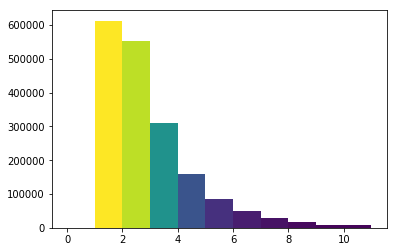

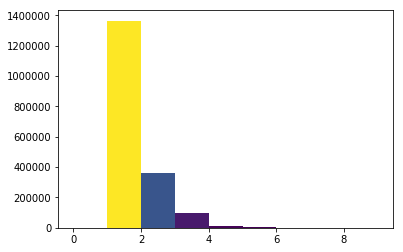

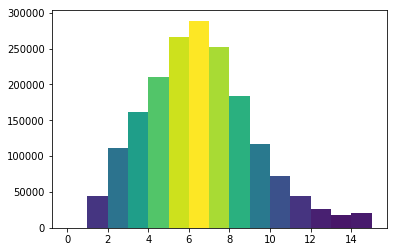

In [104]:
import matplotlib.pyplot as plt
N, bins, patches = plt.hist(s_max_length, bins=np.arange(0, 12))
fracs = N / N.max()
# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())
# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)
plt.show()

N, bins, patches = plt.hist(v_max_length, bins=np.arange(0, 10))
fracs = N / N.max()
# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())
# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)
plt.show()

N, bins, patches = plt.hist(o_max_length, bins=np.arange(0, 16))
fracs = N / N.max()
# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())
# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)
plt.show()

### Step2: Truncation

1. 1 <= len(subject) <= 7
2. 1 <= len(verb) <= 3
3. 1 <= len(object) <= 11

In [128]:
s_drop = list(np.where(s_max_length > 7)[0])
v_drop = list(np.where(v_max_length > 3)[0])
o_drop = list(np.where(o_max_length > 11)[0])
drop = list(set(s_drop + v_drop + o_drop))
print(len(drop))

145703


In [129]:
df_new = df.drop(drop)
print(df.shape, df_new.shape)
df_new.to_csv(dat_path + '/2-SVO/SVO_chunker_truncated.csv', encoding='utf-8-sig', index=False)

(1840050, 8) (1694347, 8)


### Step3: get full matched SVO data (or eliminate rare events)

In [13]:
from gensim.models import Word2Vec
d, w = 300, 7
dat_path = '/home/junhyuki/DLproject/DAT'
skipgram = Word2Vec.load(dat_path + '/3-Word2Vec/skipgram_d{}_w{}_m5_ng5'.format(d, w))
vocab = list(skipgram.wv.vocab)

import pandas as pd
import numpy as np
df = pd.read_csv(dat_path + '/2-SVO/SVO_chunker_truncated.csv', encoding='utf-8-sig')
print(df.shape)
df.head()

(1694347, 8)


,connected_url,keywords,timestamp,clean_title,location,subject,verb,object
0,http://www.reuters.com/article/2012/01/02/us-f...,Juan Salceto;Stephen Glatstein;US;FOOTBALL;ACC...,20120101,Oakland Raiders fan falls from bleachers after...,NaN,Oakland Raiders fan,falls,from bleachers after game
1,http://www.reuters.com/article/2012/01/02/us-n...,Ian Cole;Justin Abdelkader;US;NHL;BLUES;COLE;N...,20120101,Blues' Cole suspended for three games,NaN,Blues' Cole,suspended,for three games
2,http://www.reuters.com/article/2012/01/02/us-n...,Barry Trotz;Brendan Morrison;Jarome Iginla;Kev...,20120101,Kostitsyn's hat-trick helps Predators douse Fl...,NaN,Kostitsyn's hat-trick,helps,Predators douse Flames
3,http://www.reuters.com/article/2012/01/02/us-n...,Mark Leffingwell;Tim Tebow;US;NFL;BRONCOS;Spor...,20120101,"Broncos clinch AFC West, snap playoff drought",NaN,Broncos,clinch,"AFC West, snap playoff drought"
4,http://www.reuters.com/article/2012/01/02/us-c...,Cuba;Mexico;Benedict XVI;Fidel Castro;Raul Cas...,20120101,Pope Benedict XVI to visit Cuba March 26-28,NaN,Pope,Benedict,XVI to visit Cuba March 26-28


looks like there are many rare words or unuseful events in the data

In [18]:
min_count_words = []
for i, word in enumerate(event_words):
    try:
        skipgram.wv[word]
    except:
        min_count_words.append(word)

np.save(dat_path + '/min_count_words.npy', np.array(min_count_words))

print(len(min_count_words))
print(min_count_words)

58673
['kinexs', 'ineobio', 'vestakeep®', 'rmb7405', '100whf', 'paddingtville', 'débute', 'blincyto\x7f', 'melbourne\u200d\u200b', 'fantrac', 'jhcis', 'systemow', '2015—emea', 'verificient', 'kinskuch', 'nanto', 'lyding', 'belancor', 'goldtouch', 'sheerwind', 'passer\u200b', 'bluebat', 'dividends\u200b', 'sors', 'itworks', '\x7f\x7f29', 'monopoy', 'lasas', 'bluepromocode', 'tafoxiparin', 'nbs20', 'curiator', 'dsgs', '94044', 'byamazing', 'potentiate', 'brocker', 'trimodulin', 'médiamétrie', '\u200bmatches', 'truefit', '\u200dtmx', 'iboligendk', 'opsdatastore', '\u200dswitex', 'ifeelgoods', 'clouddoor', 'μείωση', 'rokt', 'gigaband', 'dynovalve', 'ecoin', 'mountainblue', '\u200d\u200bstructural', 'hospitalizes', '259222', '179258', 'muks', 'ai\u200b', '106557', 'ingerø', 'swisscard', 'verilume', '\u200drequirement', '002shr\u200b', '152980', '264900', 'perucchetti', 'goexw', 'margieswellnesscentercom', 'hoyerswerda', 'surex', 'goodnough', 'intelgenxs', 'jcj', 'vmsa', '0275shr', '\u200dla

Because of time consuming to eliminate rare events, I use `multiprocessing` and basic function is below

In [19]:
def drop_no_full_match(q1, q2, min_count_words, data_size):
    """ ls: e.g. ['macau', 'gambling', 'revenue'] """
    drop_idx = np.zeros((data_size, ))
    start = time.time()
    for i in range(data_size):
        data = q1.get()
        idx = q2.get()
        if len([x for x in data if x in min_count_words]) > 0:
            drop_idx[idx] = 1
        if (i+1) % 100000 == 0:
            end = time.time()
            print(str(i+1) + " th data / " + str((end-start)/60) + " Minutes")

    np.save(dat_path + '/drop_idx.npy', drop_idx)
    return drop_idx

In [1]:
exec(open("/home/junhyuki/DLproject/PSC/2-ExtractSVO/drop_rare_events.py").read())

loading data and numpy index >> putting them into the queue
100000 th data / 8.343563159306845 Minutes
200000 th data / 16.133457946777344 Minutes
300000 th data / 24.20601108074188 Minutes
400000 th data / 33.144268214702606 Minutes
500000 th data / 42.250943998495735 Minutes
600000 th data / 50.80965708096822 Minutes
700000 th data / 59.78772461414337 Minutes
800000 th data / 68.74787305990854 Minutes
900000 th data / 77.69587039550146 Minutes
1000000 th data / 86.73402687311173 Minutes
1100000 th data / 95.7394788980484 Minutes
1200000 th data / 104.39107826948165 Minutes
1300000 th data / 113.06527555386225 Minutes
1400000 th data / 121.89758920669556 Minutes
1500000 th data / 130.89592221577962 Minutes
1600000 th data / 139.92702066500982 Minutes
complete


Our final svo data for modelinng is... **'SVO_chunker_truncated_fullmatch.csv'**

In [14]:
idx = np.load(dat_path + '/drop_idx.npy')
print(len(np.where(idx == 1)[0]))
drop_idx = np.where(idx == 1)[0]
print(drop_idx)
df = df.drop(drop_idx)
df = df.reset_index(drop=True)

df.to_csv(dat_path + '/2-SVO/SVO_chunker_truncated_fullmatch.csv', encoding='utf-8-sig', index=False)

213220


array([      2,       7,      47, ..., 1694328, 1694339, 1694342])

### Step4: drop wrong or rare verbs

In [12]:
df = pd.read_csv(dat_path + '/2-SVO/SVO_chunker_truncated_fullmatch.csv', encoding='utf-8-sig')

from collections import Counter
count = Counter(np.array(df['verb'])).most_common()
count[:3]

[('says', 103913), ('sees', 21209), ('to', 17081)]

In [6]:
idx = np.where(df['verb'].apply(lambda x: x == "x-trackers") == True)[0]
print(len(idx))
tmp = df.iloc[idx]
tmp[['clean_title', 'subject', 'verb', 'object']].head()

8243


,clean_title,subject,verb,object
564014,db x-trackers MSCI WORLD FINANCIAL TRN INDEX E...,db,x-trackers,MSCI WORLD FINANCIAL TRN INDEX ETF Net Asset V...
564015,db x-trackers MSCI WORLD CONSUMER STAPLES TRN ...,db,x-trackers,MSCI WORLD CONSUMER STAPLES TRN INDEX ETF Net ...
564016,db x-trackers MSCI WORLD CONSUMER DISCRETIONAR...,db,x-trackers,MSCI WORLD CONSUMER DISCRETIONARY TRN INDEX ET...
564023,db x-trackers MSCI Emerging Market Short Daily...,db,x-trackers,MSCI Emerging Market Short Daily ETF Net Asset...
564025,db x-trackers MSCI ASIA EX JAPAN TRN INDEX ETF...,db,x-trackers,MSCI ASIA EX JAPAN TRN INDEX ETF Net Asset Val...


In [7]:
exec(open("/home/junhyuki/DLproject/PSC/2-ExtractSVO/drop_rare_verb.py").read())

loading data and numpy index >> putting them into the queue
100000 th data / 2.848282504081726 Minutes
200000 th data / 5.663465567429861 Minutes
300000 th data / 8.506565622488658 Minutes
400000 th data / 11.348706074555714 Minutes
500000 th data / 14.173693410555522 Minutes
600000 th data / 16.897688285509744 Minutes
700000 th data / 19.455790448188782 Minutes
800000 th data / 22.017249461015066 Minutes
900000 th data / 24.548231371243794 Minutes
1000000 th data / 27.222509562969208 Minutes
1100000 th data / 30.047384321689606 Minutes
1200000 th data / 32.86995313564936 Minutes
1300000 th data / 35.72822992801666 Minutes
1400000 th data / 38.48972778320312 Minutes
complete


In [13]:
idx = np.load(dat_path + '/drop_idx_verb.npy')
drop_idx_verb = np.where(idx == 1)[0]
print(len(drop_idx_verb))
df = df.drop(drop_idx_verb)
df = df.reset_index(drop=True)
print(df.shape)
df.head()

473764
(1007363, 8)


,connected_url,keywords,timestamp,clean_title,location,subject,verb,object
0,http://www.reuters.com/article/2012/01/02/us-f...,Juan Salceto;Stephen Glatstein;US;FOOTBALL;ACC...,20120101,Oakland Raiders fan falls from bleachers after...,NaN,Oakland Raiders fan,falls,from bleachers after game
1,http://www.reuters.com/article/2012/01/02/us-n...,Ian Cole;Justin Abdelkader;US;NHL;BLUES;COLE;N...,20120101,Blues' Cole suspended for three games,NaN,Blues' Cole,suspended,for three games
2,http://www.reuters.com/article/2012/01/02/us-n...,Mark Leffingwell;Tim Tebow;US;NFL;BRONCOS;Spor...,20120101,"Broncos clinch AFC West, snap playoff drought",NaN,Broncos,clinch,"AFC West, snap playoff drought"
3,http://www.reuters.com/article/2012/01/02/idUS...,India;N.K. Nanda;Rana Som;Commodities Markets;...,20120101,Govt appoints 3-month interim head for India's...,NaN,Govt,appoints,3-month interim head for India's NMDC
4,http://www.reuters.com/article/2012/01/02/us-c...,Colombia;Panama;United States;Venezuela;Juan d...,20120101,Colombian police kill leader of powerful drug ...,NaN,Colombian police,kill,leader of powerful drug gang


In [14]:
df.to_csv(dat_path + '/2-SVO/SVO_chunker_final.csv', encoding='utf-8-sig', index=False)

### Step5: save different word matrix for initializing paramter 'E'

In [2]:
from nltk import word_tokenize
import re

def get_event_words(df):
    """ extract unique set of words in Subject-Verb-Object Triplets """
    event_words = []
    for col in ['subject', 'verb', 'object']:
        tmp = list(df[col].apply(lambda x:
            word_tokenize(re.sub('[-&()=<>{}:;]', ' ',
                                   re.sub('[!‘’"“”#%\'*+,./?@[\\]^_`|~]', '', x)).lower())))
        append = [x for sublist in tmp for x in sublist]
        event_words.extend(append)
    unique_event_words = list(set(event_words))
    print(str(len(event_words)) +  " >>> " + str(len(unique_event_words)))
    return unique_event_words 

%time event_words = get_event_words(df)

7594565 >>> 113557
CPU times: user 4min 15s, sys: 436 ms, total: 4min 15s
Wall time: 4min 15s


In [3]:
print(event_words)
np.save(dat_path + '/event_words.npy', np.array(event_words))

['canine', '037\u200b', 'blackphone', 'taut', 'brabeck', 'altan', 'hdf', 'algeco', 'eccmid', 'cki', 'isaly', 'keet', 'dujmovits', 'kokarev', 'deficitgdp', 'nextlabs', 'rutba', 'reimbursements', 'otkritie', '3604', 'exasol', 'cocokara', 'lyndon', 'belize', 'ostentatious', 'knitwear', 'ronas', 'bitnet', 'jtc', 'aftermath', 'jafron', 'aerolineas', 'discoloured', 'factor', 'peñaflor', 'firebomb', 'konecranes', 'cedia', 'shrivels', 'nocibe', '2323', 'bnpps', '3954', 'chaucer', 'ghouta', '15mln', 'wither', 'stats', 'disregard', 'nagraid', 'computers', 'leisures', 'furthering', 'cit', 'filgotinib', 'contributions', 'mps', 'sz', 'kerings', 'aberdeens', 'robot', 'dorsavi', 'reaseguros', 'jeh', 'connectx', 'alzheimers', 'cartoon', 'amg', 'zeus', 'greensky', 'italferr', 'dubious', 'mishandling', 'foord', 'riley', 'subpac', 'kaine', 'lsp', 'podolski', 'tutsi', 'incorp', '\u200dreiterates', 'nogaholding', 'handlers', '5871', 'burfict', 'xintela', 'std', 'frodeno', '7366', 'imfc', 'exablate', 'retir

In [5]:
from gensim.models import Word2Vec

d_list = [300, 200, 100]
w_list = [7, 6, 5]

for d in d_list:
    for w in w_list:
        skipgram = Word2Vec.load(dat_path + '/3-Word2Vec/skipgram_d{}_w{}_m5_ng5'.format(d, w))
        Event_Wordmatrix = skipgram.wv[event_words].reshape(d, len(event_words))
        np.save(dat_path + '/4-SVO_vector/Event_WordMatrix_d{}_w{}.npy'.format(d, w), Event_Wordmatrix)

## Model version 1: Matching S,V,O word vectors to (S,V,O) triplets and get Average Vectors

To speed up our baseline model, we skipped inputpipeline by saving input data into numpy file.

*Note that when we get word vectors from the trained word2vec model, we need to follow same preprocessing rule for word2vec input data.

### Step1: load data and trained word2vec model

In [21]:
import pandas as pd
dat_path = '/home/junhyuki/DLproject/DAT'
df = pd.read_csv(dat_path + '/2-SVO/SVO_chunker_final.csv',
                 usecols=['clean_title', 'subject', 'verb', 'object', 'location'])

In [6]:
from gensim.models import Word2Vec
d, w = 300, 5
dat_path = '/home/junhyuki/DLproject/DAT'
skipgram = Word2Vec.load(dat_path + '/3-Word2Vec/skipgram_d{}_w{}_m5_ng5'.format(d, w))

### Step2: Matching SVO and get Average Vectors (below is example)

For the purpose of high speed, I decided to use `multiprocessing` library in python. Below is basic function
> Detailed Code can be found from **`MatchSVO_multi.py`**!

> I use **'svo_chunker_truncated_fullmatch.csv'** file to compare with other models, more exactly

In [15]:
from nltk import word_tokenize
import re
import numpy as np

def get_avgVec_phrase(phrase, w2v_model, dim):
    """ get averaged subject or relation or object vector
     Note:
      - If there is no matched word, then pass it.
      - If there is no matched word in total, then return zero vectors
      
    e.g) get_avgVec_phrase(sro_set, skipgram, 'subject', dim)
    """
    match_list = word_tokenize(re.sub('[-&()=<>{}:;]', ' ',
                                               re.sub('[!‘’"“”#%\'*+,./?@[\\]^_`|~]', '', phrase)).lower())
    nwords = 0
    avg_vec = np.zeros((1,dim),  dtype='float32')
    for word in match_list:
        if word in w2v_model.wv.vocab:
            nwords += 1
            avg_vec = np.add(avg_vec, w2v_model.wv[word])
    if nwords > 0:
        avg_vec = np.divide(avg_vec, nwords)
        
    return avg_vec

print(skipgram.vector_size)
dim = skipgram.vector_size
avg_vec = get_avgVec_phrase(df['subject'].iloc[0], skipgram, dim)
print(avg_vec.shape)

300
(1, 300)


In [1]:
exec(open("/home/junhyuki/DLproject/PSC/2-SVO/MatchSVO_multi.py").read())

svo data shape:(806055, 6)
Load Skipgram Model... 'skipgram_d100_w7_m5_ng5'----------------------------------
loading (S,V,O) data and numpy index >> putting them into the queue
100000 th (S,V,O) matched / 1.0663230816523235 Minutes
200000 th (S,V,O) matched / 1.351669470469157 Minutes
300000 th (S,V,O) matched / 1.638827673594157 Minutes
400000 th (S,V,O) matched / 1.9279899636904398 Minutes
500000 th (S,V,O) matched / 2.2174376487731933 Minutes
600000 th (S,V,O) matched / 2.5026830554008486 Minutes
700000 th (S,V,O) matched / 2.7893053253491717 Minutes
800000 th (S,V,O) matched / 3.0846017718315126 Minutes
100000 th (S,V,O) matched / 3.3739465872446694 Minutes
200000 th (S,V,O) matched / 3.6436912417411804 Minutes
300000 th (S,V,O) matched / 3.904957099755605 Minutes
400000 th (S,V,O) matched / 4.1707265416781105 Minutes
500000 th (S,V,O) matched / 4.450203486283621 Minutes
600000 th (S,V,O) matched / 4.714331777890523 Minutes
700000 th (S,V,O) matched / 4.979962392648061 Minutes
800

# Miscellaneous

In [ ]:
# import pandas as pd
# import numpy as np
# dat_path = '/home/junhyuki/DLproject/DAT'

# event_words = list(np.load(dat_path + '/event_words.npy'))
# svo = pd.read_csv(dat_path + '/2-SVO/SVO_chunker_final_unique.csv', encoding='utf-8-sig')
# print(svo.shape)
# svo.head()

In [ ]:
# import re
# from nltk import word_tokenize 
# from scipy.sparse import csc_matrix, save_npz, load_npz

# position = []
# vecS = csc_matrix((len(svo), len(event_words)), dtype=np.uint8)
# vecV = csc_matrix((len(svo), len(event_words)), dtype=np.uint8)
# vecO = csc_matrix((len(svo), len(event_words)), dtype=np.uint8)
# print(vecS)
# print(vecV)
# print(vecO)
# for i in svo.index:
#     if (i+1) % 10000 == 0:
#         print(str(i+1) + " th data done")
#     # ---------------------------------------------------------
#     row_list = word_tokenize(
#             re.sub('[-&()=<>{}:;]', ' ',
#                      re.sub('[!‘’"“”#%\'*+,./?@[\\]^_`|~]', '',
#                               svo['subject'].iloc[i])).lower())
#     position = [event_words.index(x) for x in row_list]
#     vecS[i, list(set(position))] = 1
#     # ---------------------------------------------------------
#     row_list = word_tokenize(
#             re.sub('[-&()=<>{}:;]', ' ',
#                      re.sub('[!‘’"“”#%\'*+,./?@[\\]^_`|~]', '',
#                               svo['verb'].iloc[i])).lower())
#     position = [event_words.index(x) for x in row_list]
#     vecV[i, list(set(position))] = 1
#     # ---------------------------------------------------------
#     row_list = word_tokenize(
#             re.sub('[-&()=<>{}:;]', ' ',
#                      re.sub('[!‘’"“”#%\'*+,./?@[\\]^_`|~]', '',
#                               svo['object'].iloc[i])).lower())
#     position = [event_words.index(x) for x in row_list]
#     vecO[i, list(set(position))] = 1
#     # ---------------------------------------------------------
    
# save_npz(dat_path + '/4-SVO_vector/vecS_v2.npz', vecS)
# save_npz(dat_path + '/4-SVO_vector/vecV_v2.npz', vecV)
# save_npz(dat_path + '/4-SVO_vector/vecO_v2.npz', vecO)